<h2>UNIVARIATE ANALYSIS: Gene</h2>

Q.1. What is the Gene feature type? <br>
--> Gene is a categorical feature. <br>
Q.2. Total numbers of category in gene feature and how they are distributed?

In [25]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

sys.path.append(str(Path().resolve().parent))
from src.data_split import get_train_data, get_cv_data, get_test_data, get_train_target, get_test_target, get_cv_target

In [3]:
train_df = get_train_data()
test_df = get_test_data()
cv_df = get_cv_data()
d_train_gene = train_df['Gene']

print("Total rows:", len(d_train_gene))
print("Data type:", d_train_gene.dtype)
num_unique_genes = d_train_gene.nunique()
print("\nNumber of unique genes:", num_unique_genes)
print("Missing (NaN) values:", d_train_gene.isna().sum())
print("Empty strings:", (d_train_gene.astype(str).str.strip() == "").sum())

unique_genes = d_train_gene.value_counts()
print("\nTop frequency genes: \n", unique_genes.head(10))

rare_genes = unique_genes[unique_genes == 1]
print("\nGenes appearing only once:", len(rare_genes))




Total rows: 2121
Data type: object

Number of unique genes: 234
Missing (NaN) values: 0
Empty strings: 0

Top frequency genes: 
 Gene
BRCA1     168
TP53      111
EGFR       84
PTEN       83
BRCA2      79
BRAF       63
KIT        63
ALK        52
ERBB2      47
PDGFRA     43
Name: count, dtype: int64

Genes appearing only once: 66


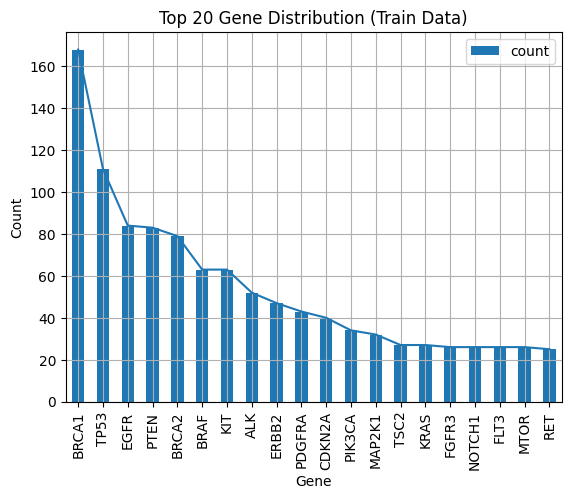

In [4]:

top_n = 20
top_genes = unique_genes.head(top_n)
top_genes.plot(kind="bar")
plt.plot(top_genes)
plt.xlabel("Gene")
plt.ylabel("Count")
plt.title(f"Top {top_n} Gene Distribution (Train Data)")
plt.grid()
plt.legend()
plt.show()



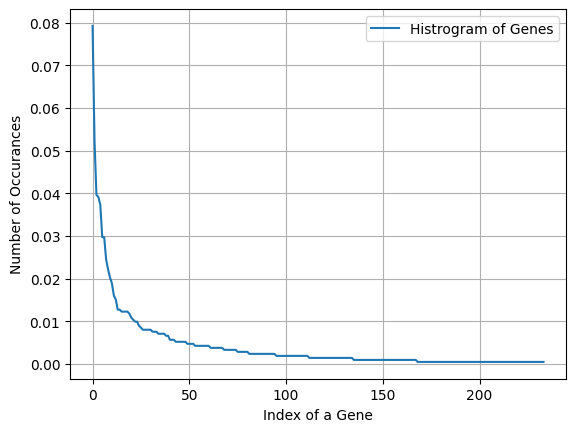

In [5]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


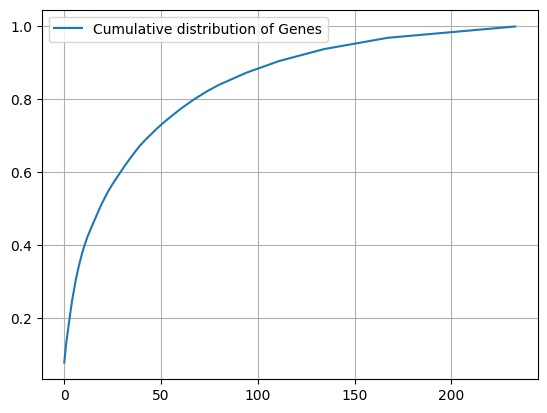

In [6]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()


* Number of unique genes : 233
* The gene BRCA1 occurs most frequently with 163 time
* Genes appearing only once: 71
* Out of 233 unique genes, the top 50 frequent genes covers around 75% of the total data

Q.3. How to featurize the Gene feature? </br>
--> One hot Encoding and Response coding

In [ ]:
# ONE HOT ENCODING
gene_encoder = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=True
)

train_gene_ohe = gene_encoder.fit_transform(train_df[["Gene"]])
test_gene_ohe = gene_encoder.transform(test_df[["Gene"]])
cv_gene_ohe = gene_encoder.transform(cv_df[["Gene"]])



In [ ]:
# RESPONSE CODING
gene_class_dict = defaultdict(list)

for gene, cls in zip(train_df["Gene"], train_df["Class"]):
    gene_class_dict[gene].append(cls)

sum(len(v) for v in gene_class_dict.values()) == len(train_df)

True

In [ ]:
NUM_CLASSES = 9
alpha = 1  # Laplace smoothing

gene_response_dict = {}

for gene, class_list in gene_class_dict.items():
    counts = np.zeros(NUM_CLASSES)

    for cls in class_list:
        counts[cls - 1] += 1   # class labels 1–9 → index 0–8

    # Laplace smoothing + normalization
    probs = (counts + alpha*10) / (counts.sum() + alpha * 90)

    gene_response_dict[gene] = probs

In [ ]:
global_class_probs = (
    train_df["Class"]
    .value_counts(normalize=True)
    .sort_index()
    .values
)

def response_encode_gene(series, response_dict, fallback):
    return np.vstack([
        response_dict.get(gene, fallback)
        for gene in series
    ])

X_train_gene_rc = response_encode_gene(
    train_df["Gene"], gene_response_dict, global_class_probs
)

X_test_gene_rc = response_encode_gene(
    test_df["Gene"], gene_response_dict, global_class_probs
)

X_cv_gene_rc = response_encode_gene(
    cv_df["Gene"], gene_response_dict, global_class_probs
)



array([[0.18604651, 0.03875969, 0.08527132, ..., 0.03875969, 0.03875969,
        0.03875969],
       [0.08270677, 0.09774436, 0.12781955, ..., 0.29323308, 0.07518797,
        0.07518797],
       [0.18604651, 0.03875969, 0.08527132, ..., 0.03875969, 0.03875969,
        0.03875969],
       ...,
       [0.12087912, 0.10989011, 0.10989011, ..., 0.10989011, 0.10989011,
        0.10989011],
       [0.13043478, 0.10869565, 0.10869565, ..., 0.10869565, 0.10869565,
        0.10869565],
       [0.09345794, 0.14953271, 0.09345794, ..., 0.18691589, 0.09345794,
        0.09345794]], shape=(2121, 9))

Q.4. How good is the gene feature in predicting yi(Class label)? <br>
--> We can find this by building a model predicting yi using gene feature only.

For values of alpha =  1e-06 The log loss is: 1.284150024679248
For values of alpha =  1e-05 The log loss is: 1.2082161203592663
For values of alpha =  0.0001 The log loss is: 1.179414866116506
For values of alpha =  0.001 The log loss is: 1.2283494658704144
For values of alpha =  0.01 The log loss is: 1.3697126831632638
For values of alpha =  0.1 The log loss is: 1.4901538107394123
For values of alpha =  1 The log loss is: 1.5203746006982979


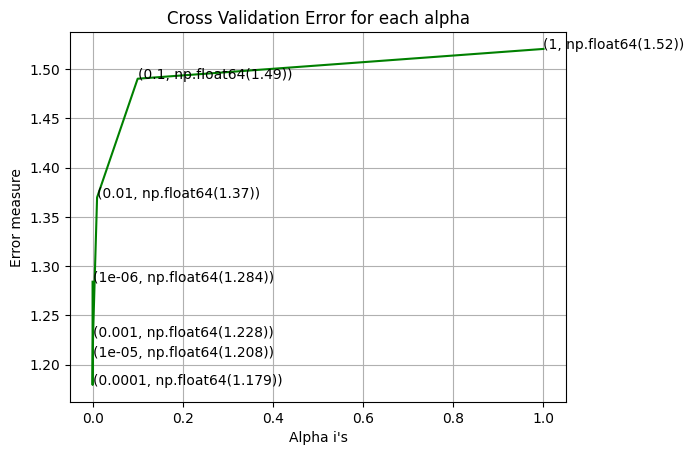

For values of best alpha =  0.0001 The train log loss is: 1.0014922567901006
For values of best alpha =  0.0001 The cross validation log loss is: 1.179414866116506
For values of best alpha =  0.0001 The test log loss is: 1.1413367769414735


In [39]:
y_train = get_train_target()
y_test = get_test_target()
y_cv = get_cv_target()

cv_log_error_array=[]

# selection of hyperparameter alpha
# creation of alpha and their corresponding  logloss
alpha_list = [10 ** x for x in range(-6, 1)] # hyperparam for SGD classifier
for index, alpha in enumerate(alpha_list):
    # define the model as logistic regression
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
    # define the calibration model
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")

    # # training the model(redundant)
    # clf.fit(train_gene_ohe, y_train)

    # training the calibration model
    sig_clf.fit(train_gene_ohe, y_train)
    
    # after traning, predict the probability for cv data with the calibration model
    predict_y = sig_clf.predict_proba(cv_gene_ohe)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=sig_clf.classes_))
    print('For values of alpha = ', alpha, "The log loss is:", cv_log_error_array[index])

fig, ax = plt.subplots()
ax.plot(alpha_list, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha_list[i],np.round(txt,3)), (alpha_list[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# the best alpha
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha_list[best_alpha], penalty='l2', loss='log_loss', random_state=42)

# redundant
# clf.fit(train_gene_ohe, y_train)

# define calibration model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_ohe, y_train)

predict_y = sig_clf.predict_proba(train_gene_ohe)
print('For values of best alpha = ', alpha_list[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(cv_gene_ohe)
print('For values of best alpha = ', alpha_list[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(test_gene_ohe)
print('For values of best alpha = ', alpha_list[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_))


For values of alpha =  1e-06 The log loss is: 1.3094683560818194
For values of alpha =  1e-05 The log loss is: 1.315632505913512
For values of alpha =  0.0001 The log loss is: 1.3283090885614697
For values of alpha =  0.001 The log loss is: 1.377978755577754
For values of alpha =  0.01 The log loss is: 1.4086968930420694
For values of alpha =  0.1 The log loss is: 1.4109688588868712
For values of alpha =  1 The log loss is: 1.4202054594144677


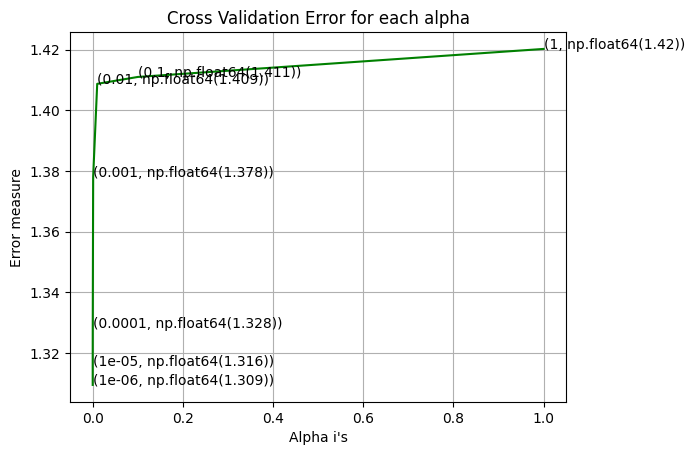

For values of best alpha =  1e-06 The train log loss is: 1.1831486662265331
For values of best alpha =  1e-06 The cross validation log loss is: 1.3094683560818194
For values of best alpha =  1e-06 The test log loss is: 1.2852778512798204


: 

In [ ]:
cv_log_error_array=[]

# selection of hyperparameter alpha
# creation of alpha and their corresponding  logloss
alpha_list = [10 ** x for x in range(-6, 1)] # hyperparam for SGD classifier
for index, alpha in enumerate(alpha_list):
    # define the model as logistic regression
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log_loss', random_state=42)
    # define the calibration model
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")

    # # training the model(redundant)
    # clf.fit(train_gene_ohe, y_train)

    # training the calibration model
    sig_clf.fit(X_train_gene_rc, y_train)
    
    # after traning, predict the probability for cv data with the calibration model
    predict_y = sig_clf.predict_proba(X_cv_gene_rc)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=sig_clf.classes_))
    print('For values of alpha = ', alpha, "The log loss is:", cv_log_error_array[index])

fig, ax = plt.subplots()
ax.plot(alpha_list, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha_list[i],np.round(txt,3)), (alpha_list[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

# the best alpha
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha_list[best_alpha], penalty='l2', loss='log_loss', random_state=42)

# redundant
# clf.fit(train_gene_ohe, y_train)

# define calibration model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_gene_rc, y_train)

predict_y = sig_clf.predict_proba(X_train_gene_rc)
print('For values of best alpha = ', alpha_list[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_cv_gene_rc)
print('For values of best alpha = ', alpha_list[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test_gene_rc)
print('For values of best alpha = ', alpha_list[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_))


<b>The model gives train loss of 1.001, test loss of 1.141 and cv loss of 1.17. <br>
While the random model give CV log loss of 2.494 and test log loss of 2.519. <br>
Thus, gene is an useful feature</b>

<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>